# Install and import necessary packages

In [1]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
import os

## Gathering Data
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [7]:
key = os.environ.get('AZURE_SEARCH_KEY', '8a8fc60ce9ce42e891e703e8f6d0d223')

Once we obtain the key, we can use *search_images_bing* function to search images. Let's use Frodo Baggins as an example. The second line of the code below indicates that we are going to download the URLs of 150 Frodo's pictures. We can use *len* function to check how many images we got.

In [8]:
results = search_images_bing(key, 'Frodo Baggins')
ims = results.attrgot('contentUrl')
len(ims)

150

Now we got 150 photos of Frodo from Bing image search. Let's look at one of them.

In [9]:
dest = 'images/frodo.jpg'
download_url(ims[0], dest)

Path('images/frodo.jpg')

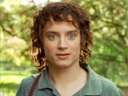

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

Let's define the hobbiteses by including the names of the 4 hobbits. Then we use fastai's *download_images* function to download all the image URLs for each of the hobbit, and putting each into a separate folder.

In [11]:
hobbiteses = 'Frodo Baggins','Samwise Gamgee','Merry Brandybuck','Pippin Took'
path = Path('hobbits')

In [12]:
if not path.exists():
    path.mkdir()
    for o in hobbiteses:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

Let's look at the image files saved under the path.

In [13]:
fns = get_image_files(path)
fns

(#543) [Path('hobbits/Pippin Took/00000047.jpg'),Path('hobbits/Pippin Took/00000055.jpg'),Path('hobbits/Pippin Took/00000036.jpg'),Path('hobbits/Pippin Took/00000030.jpg'),Path('hobbits/Pippin Took/00000097.jpg'),Path('hobbits/Pippin Took/00000148.jpg'),Path('hobbits/Pippin Took/00000112.jpg'),Path('hobbits/Pippin Took/00000142.png'),Path('hobbits/Pippin Took/00000093.jpg'),Path('hobbits/Pippin Took/00000090.jpg')...]

At this point, it is good to check if there are any corrupted files. *verify_images* is a function that returns an object of type L. The object has a *map* method.

In [14]:
failed = verify_images(fns)
failed

(#0) []

Let's remove the failed images by unlinking them.

In [15]:
failed.map(Path.unlink);

## From Data to DataLoaders

Now we have our images for the hobbits. The object *DataLoaders* can help us assemble the data into a format that is appropriate for model training.

The *blocks* contain a tuple of independent variable and dependent variable. The independent variable is things that we use to make predictions form, in this case, it is the images we downloaded. The dependent varibles are our targets, which are 4 different hobbits. The *blocks* also tell fastai what kinds of data we are working with.

The *get_items* is telling it the way to get the list of items. The *get_image_files* returns a list of all images within the path.

The *splitter* tells the way to create the validation set. *RandomSplitter* allows fastai to split the images into training set (80% of the images) and validation set (20% of the images). To ensure fastai is spliting the list of images into validation set everytime we run the notebook, we put a seed number, and later on we call the seed number to get the exact same validation set.

*get_y* or *get_dependent_variable* tells it the way to label the images. *parent_label* is a fastai function that gets the folder name. By doing this, we label the images by just using their corresponding folder name.

Lastly, *item_tfms* contains the resized images of 128 pixels. *RandomResizedCrop* will randomly select part of the image and then crop to just that part. It is also a specific example of a more general techinique called data augmentation. We use *min_scale* to decide 30% of the image to select at minimum each time. This is a relatively better way to prevent overfitting because every epoch we are feeding the model a different image

In [16]:
hobbits = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=815),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128, min_scale=0.3))

In [17]:
dls = hobbits.dataloaders(path)

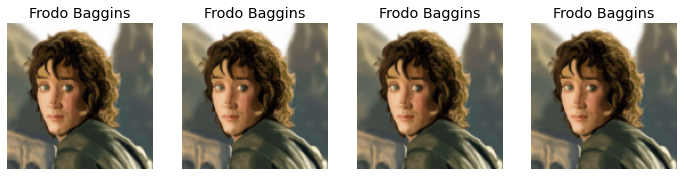

In [18]:
dls.valid.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

Data augmentation means creating random variations of our input data so they appear differently. Common techniques include rotating, flipping, perspective wrapping, changing brightess, changing contrast, etc.
We use *batch_tfms* to perform transformation on a batch using the GPU, which can save us lots of time!

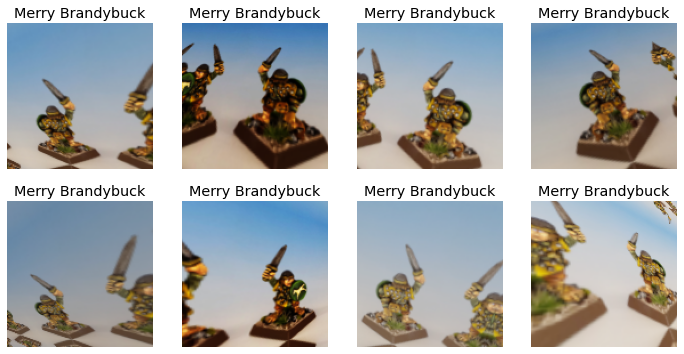

In [20]:
hobbits = hobbits.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = hobbits.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

Now we have assembled our data into a format for model training. Let's train an image classifer with it.

In [21]:
hobbits = hobbits.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = hobbits.dataloaders(path)

Now we use the *Learner* and fine tune it.

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.312958,1.753922,0.592593,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.486919,1.306216,0.453704,00:08
1,1.372864,1.132378,0.388889,00:08
2,1.268308,1.081750,0.361111,00:08
3,1.093114,1.029306,0.296296,00:08
4,0.954589,1.006706,0.305556,00:08
5,0.847973,1.008560,0.333333,00:08
6,0.741273,0.998441,0.351852,00:09
7,0.652218,0.974963,0.314815,00:08
8,0.581507,0.957404,0.305556,00:08
9,0.539137,0.947283,0.305556,00:08


After train for 10 epoches, our model has an error rate around 30%. Fair enough. We can use a confusion matrix to visualize any misidentification. 

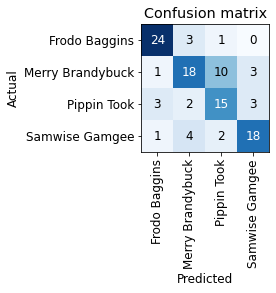

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

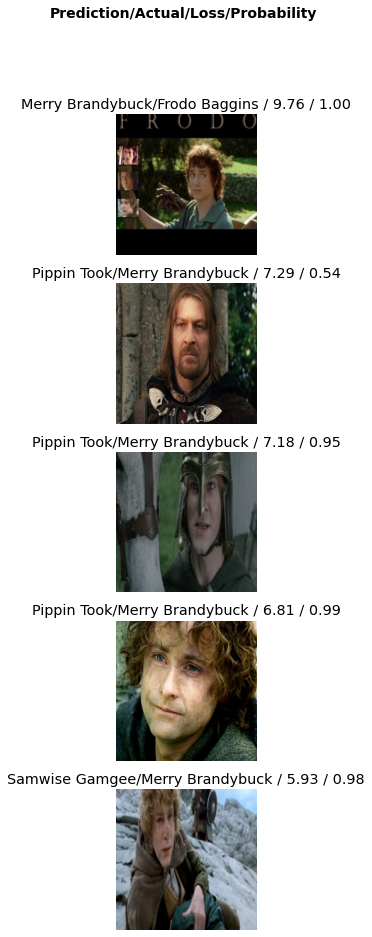

In [24]:
interp.plot_top_losses(5, nrows=5)

From the confusion matrix and top 5 misidentifications, we notice there are some errors going on. The major confusion happens on identifying whether it is Merry or Pippin. 
Let's clean the data using this nice GUI below.

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [31]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

After we use the cleaner to clean both datasets (training and validation) for each hobbit (Frodo, Merry, Pippin, Sam), and delete or change the images. Let's retrain the model and see its performance.

In [32]:
dls = hobbits.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.285150,1.727982,0.567308,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.604267,1.215392,0.442308,00:08
1,1.465842,0.929600,0.326923,00:08
2,1.315710,0.822327,0.269231,00:08
3,1.168783,0.796479,0.211538,00:08
4,1.009583,0.660252,0.221154,00:08
5,0.873830,0.649577,0.230769,00:08
6,0.784462,0.635030,0.230769,00:08
7,0.702688,0.607928,0.221154,00:08
8,0.628360,0.582658,0.211538,00:08
9,0.572112,0.584492,0.230769,00:08


By cleaning the datasets, we managed to lower the error rate from 30% to 23%.

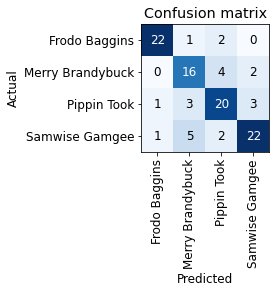

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We significantly decreased the misidentification between Merry and Pippin.

## Turning Your Model into an Online Application

### Using the Model for Inference

Now we can try to use our model to make an inference/prediction. The model object is stored in the variable *learn_inf*.

In [34]:
learn.export()

In [35]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [36]:
learn_inf = load_learner(path/'export.pkl')

Let's input a sample image.

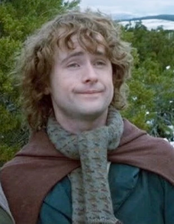

In [38]:
ims = ['https://static.wikia.nocookie.net/pjhobbitlotr/images/8/86/PippinBoyd.png']
dest = 'images/test_pippin.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(224,224)

We use a sample image of Pippin, let's see if our model can correctly identify it (hopefully not identified as Merry).

In [39]:
learn_inf.predict('images/test_pippin.jpg')

('Pippin Took',
 TensorBase(2),
 TensorBase([3.0797e-04, 3.3935e-05, 9.9958e-01, 8.0207e-05]))

In [40]:
learn_inf.dls.vocab

['Frodo Baggins', 'Merry Brandybuck', 'Pippin Took', 'Samwise Gamgee']

Our model identifies the sample image as Pippin Took, which is the 3rd index in the vocab list. The probability of being Pippin Took is 99.958%. 

## Creating a Notebook App from the Model

In [45]:
# make the upload button
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [46]:
# retrieve the user uploaded image
img = PILImage.create(btn_upload.data[-1])

# set up the output widget to display the user uploaded image
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

# get the identification and its probability
pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

# define a handle function to handle the event when user click the classify button
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run = widgets.Button(description='Classify')
btn_run.on_click(on_click_classify)

In [47]:
# now assemble the buttons and callbacks
VBox([widgets.Label('Identify your hobbitese!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 